In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import jax

In [3]:
mean1, cov1 = np.array([0,0]),np.array([[1,0.3],[0,.3]])
mean2, cov2 = np.array([1,1]),np.array([[1,-.2],[-.2,1]])

hypo1 = sps.multivariate_normal(mean1,cov1)
hypo2 = sps.multivariate_normal(mean2, cov2)

def samples(n):
    a = hypo1.rvs(n)
    b = hypo2.rvs(n)
    return a,b

def stat1(x):
    return x[...,0]

def stat2(x):
    return x[...,1]

def stat3(x):
    return x[...,1] + x[...,0]

@jax.jit
def stat_np(x):
    return jax.scipy.stats.multivariate_normal.logpdf(x,mean2,cov2)-jax.scipy.stats.multivariate_normal.logpdf(x,mean1,cov1)

In [51]:
stats =  [stat1,stat2,stat3,stat_np]
labels = [r'$x_1$',r'$x_2$',r'$x_1+x_2$','lhood-ratio']

hypos = a,b = samples(int(1e5))
applied_stats = [[np.array(stat(h)) for h in hypos] for stat in stats]

/Users/lukasheinrich/Code/madjax_for_acat/_venv/lib/python3.7/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


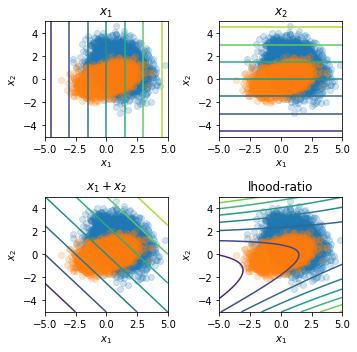

In [62]:
grid = xi,yi =  np.mgrid[-5:5:101j,-5:5:101j]
X = np.swapaxes(grid,0,-1).reshape(-1,2)
zi_list = [jax.vmap(stat)(X).reshape(101,101).T for stat in stats]

def plot_test_stat(ax,a,b,zi,label):
    ax.scatter(b[:5000,0],b[:5000,1], alpha = 0.2)
    ax.scatter(a[:5000,0],a[:5000,1], alpha = 0.2)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.contour(xi,yi,zi)
    ax.set_title(label)


f,axarr = plt.subplots(2,2)
for ax,zi,label in zip(axarr.ravel(), zi_list,labels):
    plot_test_stat(ax,a,b,zi,label)
f.set_tight_layout(True)
f.set_size_inches(5,5)
f.savefig('neyman-pearson-summary-contours.png')


/Users/lukasheinrich/Code/madjax_for_acat/_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys


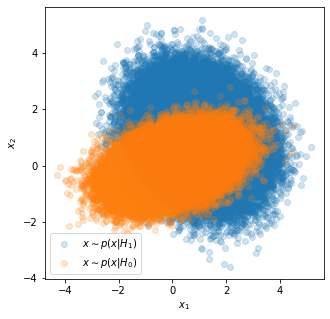

In [53]:
plt.scatter(b[:,0],b[:,1], alpha = 0.2, label =  r'$x\sim p(x|H_1)$')
plt.scatter(a[:,0],a[:,1], alpha = 0.2, label =  r'$x\sim p(x|H_0)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.gcf().set_size_inches(5,5)
plt.legend()
plt.savefig('neyman-pearson-setup.png')

In [54]:
def get_roc_curve(a,b,bins):
    def get_errs(a,b,cut):
        size = len(a[a>cut])/len(a)
        power = len(b[b>cut])/len(b)
        return size,power
    return np.array([get_errs(a,b,cut) for cut in bins])

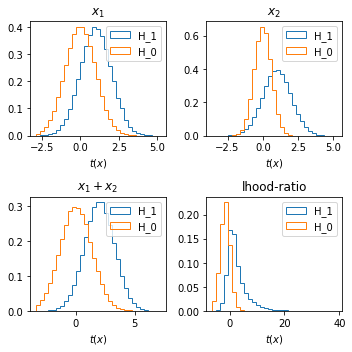

In [60]:
def plot_projection(ax,applied,label):
    _,bins,_ = ax.hist(applied[1], bins = 31, histtype='step', density=True, label = 'H_1')
    _,bins,_ = ax.hist(applied[0], bins=bins, histtype='step', density=True, label = 'H_0')
    ax.legend()
    ax.set_xlabel(r'$t(x)$')
    ax.set_title(label)
    

f,axarr = plt.subplots(2,2)
for ax,applied,label in zip(axarr.ravel(), applied_stats,labels):
    plot_projection(ax,applied,label)
f.set_tight_layout(True)
f.set_size_inches(5,5)
f.savefig('neyman-pearson-summary-stats.png')

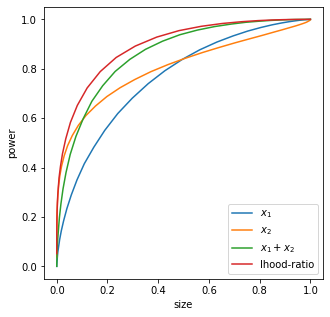

In [61]:
def plot_roc(ax,applied,label):
    _,bins = np.histogram(applied[0], bins=51)
    roc = get_roc_curve(applied[0],applied[1],bins)
    ax.plot(roc[:,0],roc[:,1], label = label)
    ax.set_xlabel('size')
    ax.set_ylabel('power')

f,ax = plt.subplots(1,1)
for applied,label in zip(applied_stats, labels):
    plot_roc(ax,applied,label)
plt.legend()
plt.xlabel('size')
plt.ylabel('power')
plt.gcf().set_size_inches(5,5)
f.savefig('neyman-pearson-summary-roc.png')

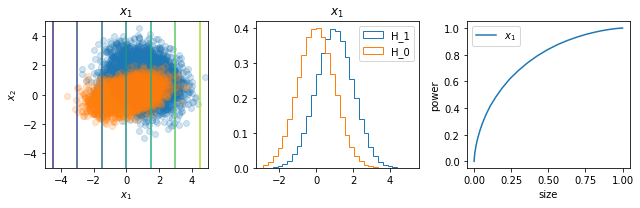

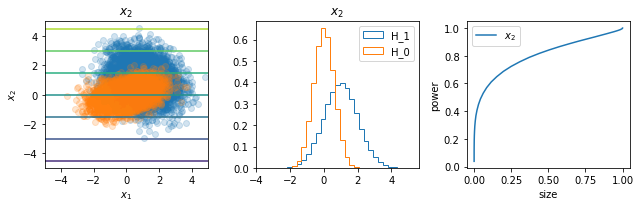

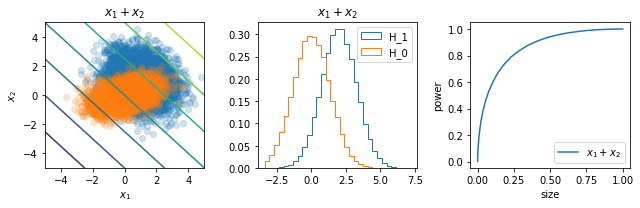

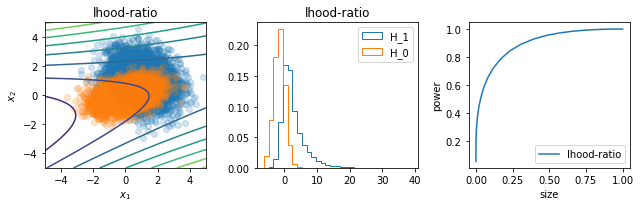

In [58]:
for i in range(4):
    f,axarr = plt.subplots(1,3)
    ax = axarr[0]
    plot_test_stat(ax,a,b,zi_list[i],labels[i])
    ax = axarr[1]
    plot_projection(ax,applied_stats[i],labels[i])
    ax.legend()
    ax = axarr[2]
    plot_roc(ax,applied_stats[i],labels[i])
    ax.legend()
    f.set_size_inches(9,3)
    f.set_tight_layout(True)
    f.savefig(f'neyman_pearson{i}.png')

